# Bayes Net Work (Parts 4 and 7) - Quinn Thompson

Before we dig into the higher level bayesian classification models that are the center of our work, we should attempt to unpack the potential relationships that currently exist in our data for our target variable. In our case, our target is the landmark-style survival endpoint for CNS tumor patients, which occurs for CNS cases that observe a death in the first 730 days.

In [68]:

import pandas as pd
import numpy as np
import os
import pathlib
import warnings
# probml_utils not available - using alternative visualization
# import probml_utils.pgmpy_utils as pgm
from pgmpy.estimators import MaximumLikelihoodEstimator
from collections.abc import Iterable, Mapping, Sequence
import pgmpy
import matplotlib.pyplot as plt
import seaborn as sns
from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.estimators import HillClimbSearch, ExhaustiveSearch, BIC, AIC
from pgmpy.estimators.StructureScore import K2, BDeu
from causalgraphicalmodels import CausalGraphicalModel
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination
pd.options.display.max_rows = 500
pd.options.display.max_columns = 300
from pgmpy.sampling import BayesianModelSampling
from pgmpy.estimators import HillClimbSearch, ExhaustiveSearch, PC, TreeSearch, BIC, MaximumLikelihoodEstimator
from pgmpy.metrics import structure_score
from sklearn.model_selection import train_test_split
from pgmpy.sampling import BayesianModelSampling
from pgmpy.metrics import structure_score
from scipy.stats import chi2_contingency

import networkx as nx
from matplotlib import pyplot as plt



import os
import pathlib
import sys
import warnings

probml_path = os.path.abspath('../probml-utils')
if probml_path not in sys.path:
    sys.path.insert(0, probml_path)

import probml_utils.pgmpy_utils as pgm
print("probml_utils imported successfully")
    
warnings.filterwarnings("ignore")

diagnosis_data = pd.read_csv("../datasets/C3DC Diagnosis.csv")
participant_data = pd.read_csv("../datasets/C3DC Participants.csv")
treatment_data = pd.read_csv("../datasets/C3DC Treatment Data.csv")
treatment_response_data = pd.read_csv("../datasets/C3DC Treatment Response.csv")
survival_data = pd.read_csv("../datasets/C3DC Survival.csv")

probml_utils imported successfully


The code below uses the same framework as our initial data engineering and EDA setup, defining our target variable.

In [9]:
# ---------------------------------------------------------
# Step 1: Target Variable (Classification) - CNS Tumor Flag
# ---------------------------------------------------------
cns_codes = ['C70', 'C71', 'C72']

def check_cns(site):
    if pd.isna(site):
        return 0
    for code in cns_codes:
        if code in str(site):
            return 1
    return 0

diagnosis_data['is_cns_tumor'] = diagnosis_data['Anatomic Site'].apply(check_cns)
# Aggregate per participant (Max: if any diagnosis is CNS, label as 1)
target_df = diagnosis_data.groupby('Participant ID')['is_cns_tumor'].max().reset_index()

# ---------------------------------------------------------
# Step 2: Feature - Age (Numeric)
# ---------------------------------------------------------
diagnosis_data['Age_numeric'] = pd.to_numeric(diagnosis_data['Age at Diagnosis (days)'], errors='coerce')
# Take the minimum age (age at first diagnosis)
age_df = diagnosis_data.groupby('Participant ID')['Age_numeric'].min().reset_index()
age_df.rename(columns={'Age_numeric': 'Age_at_Diagnosis_Days'}, inplace=True)

# ---------------------------------------------------------
# Step 4: Survival Data Processing (New Step!)
# ---------------------------------------------------------
# Convert Age at Last Contact to numeric
survival_data['Age_Last_Contact'] = pd.to_numeric(survival_data['Age at Last Known Survival Status'], errors='coerce')

# Define Event (1=Dead, 0=Alive/Censored)
# "Dead" is the event. "Alive", "Not Reported", "Unknown" are censored (0).
survival_data['Event_Status'] = survival_data['Last Known Survival Status'].apply(lambda x: 1 if x == 'Dead' else 0)
# Select only necessary columns to avoid duplicates
survival_clean = survival_data[['Participant ID', 'Age_Last_Contact', 'Event_Status']].drop_duplicates('Participant ID')


#print("Survival Columns", survival_clean.columns.tolist())
#print("Target Columns", target_df.columns.tolist())
#print("Age Columns", age_df.columns.tolist())
#print("Participant Columns", participant_data.columns.tolist())

# ---------------------------------------------------------
# Step 5: Merging All Data
# ---------------------------------------------------------
df_merged = pd.merge(treatment_data, target_df, on='Participant ID', how='left')
df_merged = pd.merge(df_merged, age_df, on='Participant ID', how='left')
df_merged = pd.merge(df_merged, survival_clean, on='Participant ID', how='left') # <--- Merge Survival
df_merged = pd.merge(df_merged, participant_data, on='Participant ID', how='left')

# ---------------------------------------------------------
# Step 6: Final Preprocessing & Calculations
# ---------------------------------------------------------

# 1. Filter: Keep only rows where 'is_cns_tumor' is defined
df_merged = df_merged.dropna(subset=['is_cns_tumor'])

# 2. Impute Missing Age (Median) & Add Flag
median_age = df_merged['Age_at_Diagnosis_Days'].median()
df_merged['Age_missing_flag'] = df_merged['Age_at_Diagnosis_Days'].apply(lambda x: 1 if pd.isna(x) else 0)
df_merged['Age_at_Diagnosis_Days'] = df_merged['Age_at_Diagnosis_Days'].fillna(median_age)

# 4. Handle Categorical Missings (Race, Sex)
categorical_cols = ['Race', 'Sex at Birth']

#print(df_merged.head())
for col in categorical_cols:
    df_merged[col] = df_merged[col].fillna('Unknown')
    df_merged[col] = df_merged[col].replace('Not Reported', 'Unknown')

# 5. Calculate Survival Time (Time-to-Event)
# Survival Time = Age at Last Contact - Age at Diagnosis
df_merged['Survival_Time_Days'] = df_merged['Age_Last_Contact'] - df_merged['Age_at_Diagnosis_Days']

THRESHOLD = 730  # 2 years in days

# Target: 1 if patient died within threshold, 0 otherwise
df_merged['Target'] = np.where(
    (df_merged['Event_Status'] == 1) & (df_merged['Survival_Time_Days'] < THRESHOLD),
    1,
    0
)

df_final_bayeswork = df_merged.copy()
#print("final columns check:", df_final_bayeswork.columns.tolist())
df_final_bayeswork = df_final_bayeswork.drop(columns=["Study ID_x"])
df_final_bayeswork.rename(columns={"Study ID_y": "Study_ID"}, inplace=True)
print("Final Columns:", df_final_bayeswork.columns.tolist())

Final Columns: ['Participant ID', 'Treatment ID', 'Age at Treatment Start', 'Age at Treatment End', 'Treatment Type', 'Treatment Agent', 'is_cns_tumor', 'Age_at_Diagnosis_Days', 'Age_Last_Contact', 'Event_Status', 'Race', 'Sex at Birth', 'Study_ID', 'Age_missing_flag', 'Survival_Time_Days', 'Target']


We have 319 survival endpoint cases with our data (11.1% of records).

In [54]:
df_final_bayeswork['Target'].value_counts() 

Target
0    2553
1     319
Name: count, dtype: int64

Our dataset contains 13 unique treatment types with 25 unique treatment agents for our participants. The most common demographic profile of our participants are white, male individuals that underwent a surgical procedure with no reported treatment agent. The average survival time for participants sits at 580 days, considerably under our landmark surival endpoint threshold of 730.

In [56]:
print("Final Dataset Overall Summary")
df_final_bayeswork.describe(include='all').T


Final Dataset Overall Summary


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Participant ID,2872,1676,08e314c4b8badeb4ee39,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Treatment ID,2872,2872,87a10fc7-b27b-5e4d-ab90-aa035ec67063,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age at Treatment Start,2872,1,Not Reported,2872,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age at Treatment End,2872,1,Not Reported,2872,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Treatment Type,2872,13,Surgical Procedure,1512,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Treatment Agent,2872,25,Not Reported,2585,NaN,NaN,NaN,NaN,NaN,NaN,NaN
is_cns_tumor,2872.0,NaN,NaN,NaN,1.0,0.0,1.0,1.0,1.0,1.0,1.0
Age_at_Diagnosis_Days,2872.0,NaN,NaN,NaN,3193.659123,2073.452423,7.0,1403.75,2947.0,4850.0,9316.0
Age_Last_Contact,1958.0,NaN,NaN,NaN,3676.777835,2100.138885,105.0,1871.0,3414.5,5297.5,9411.0
Event_Status,2817.0,NaN,NaN,NaN,0.129215,0.335498,0.0,0.0,0.0,0.0,1.0


The overall dataset has the following data dictionary:
- Participant ID (String, ID) - A unique identifier for participants in the original data group
- Treatment ID (String, ID) - A unique identifier for the treatment provided to participants in the original data group
- Treatment Type (String, Categorical) - The type of treatment performed for a given participant
- Treatment Agent (String, Categorical) - The agent of delivery for a treatment type for a given participant
- is_cns_tumor (Boolean, Categorical) - A verification column to assure our dataset focuses on CNS cases
- Age at Diagnosis Days (Integer, Numeric) - The age of the participant was at the date of their original diagnosis
- Age Last Contact (Integer, Numeric) - THe age of the participant at the last point of contact from researchers
- Event Status
- Race (String, Categorical) - The race of the participant
- Sex at Birth (String, Categorical) - The sex of the participant at birth
- Age_missing_flag (Boolean, Categorical) - A flagging column used to identify cases where participants do not have their age reported
- Survival Time Days (Int, Numeric) - The amount of days the participant has survived during the study
- Target (Boolean, Categorical) - Our target landmark survival endpoint

In [11]:
print("Data Info:")
df_final_bayeswork.info()

Data Info:
<class 'pandas.core.frame.DataFrame'>
Index: 2872 entries, 0 to 2871
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Participant ID          2872 non-null   object 
 1   Treatment ID            2872 non-null   object 
 2   Age at Treatment Start  2872 non-null   object 
 3   Age at Treatment End    2872 non-null   object 
 4   Treatment Type          2872 non-null   object 
 5   Treatment Agent         2872 non-null   object 
 6   is_cns_tumor            2872 non-null   float64
 7   Age_at_Diagnosis_Days   2872 non-null   float64
 8   Age_Last_Contact        1958 non-null   float64
 9   Event_Status            2817 non-null   float64
 10  Race                    2872 non-null   object 
 11  Sex at Birth            2872 non-null   object 
 12  Study_ID                2872 non-null   object 
 13  Age_missing_flag        2872 non-null   int64  
 14  Survival_Time_Days      1958 non-n

In [31]:
df_final_bayeswork.columns

Index(['Participant ID', 'Treatment ID', 'Age at Treatment Start',
       'Age at Treatment End', 'Treatment Type', 'Treatment Agent',
       'is_cns_tumor', 'Age_at_Diagnosis_Days', 'Age_Last_Contact',
       'Event_Status', 'Race', 'Sex at Birth', 'Study_ID', 'Age_missing_flag',
       'Survival_Time_Days', 'Target'],
      dtype='object')

In [12]:
for col in [x for x in df_final_bayeswork.drop(columns=['Participant ID', "Treatment ID", "Study_ID"], axis=1).columns if df_final_bayeswork.drop(columns=['Participant ID', "Treatment ID", "Study_ID"], axis=1)[x].dtype == 'object']:
    print(df_final_bayeswork[col].value_counts())

Age at Treatment Start
Not Reported    2872
Name: count, dtype: int64
Age at Treatment End
Not Reported    2872
Name: count, dtype: int64
Treatment Type
Surgical Procedure                      1512
Pharmacotherapy                          349
Radiation Therapy                        293
Chemotherapy                             274
Proton Beam Radiation Therapy            208
Photon Beam Radiation Therapy             69
Autologous Stem Cell Transplantation      51
Unknown                                   50
Stem Cell Transplant                      38
Immunotherapy                             19
Electron Beam Radiation Therapy            5
Targeted Molecular Therapy                 2
Cellular Therapy                           2
Name: count, dtype: int64
Treatment Agent
Not Reported                                                    2585
Vincristine                                                       48
Carboplatin                                                       37
Temozolomide 

The distribution of our survival times is fairly right skewed, with a mean of 508 days and a median of 382. Most of our records fall below the survival threshold. The age at diagnosis is fairly uniform with a mean of 3182 days and a median of 2947, considerably after the survival time of most of our participants. Our last contacted date attains a similar mean, median, and distribution with a mean of 3677 days and a median of 3414 days respectively. The top three most common treatments outside of those that are unreported or surgical procedures are pharmacotherapy, radiation therapy, and chemotherapy, which are all fairly common treatments for tumors. The most common treatment agents used for participants were vincristine (a vince alkaloid that impedes the division of cancer cells), carboplatin (an agent that interferes with the growth of cancer cells), and temozolomide (an agent that stops cancer cells from making DNA, preventing growth).

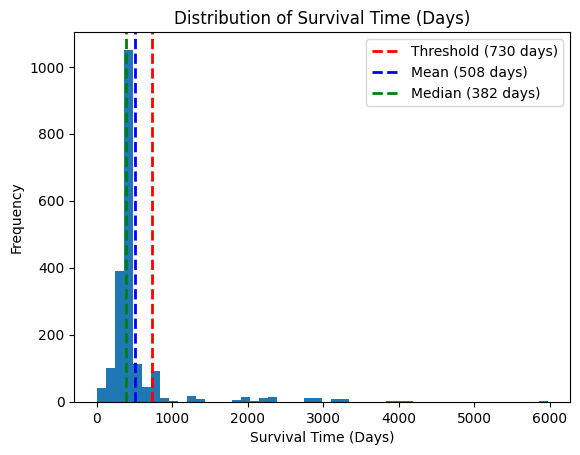

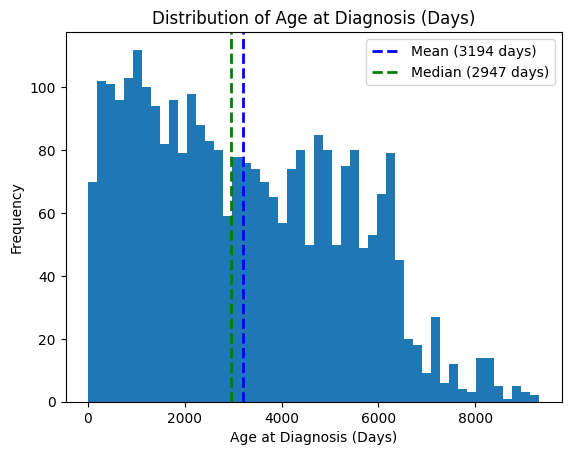

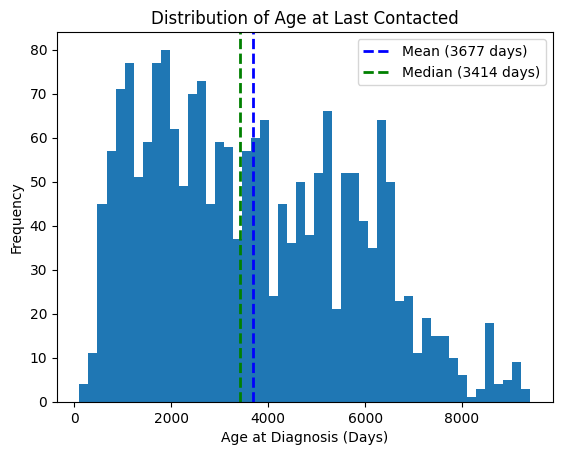

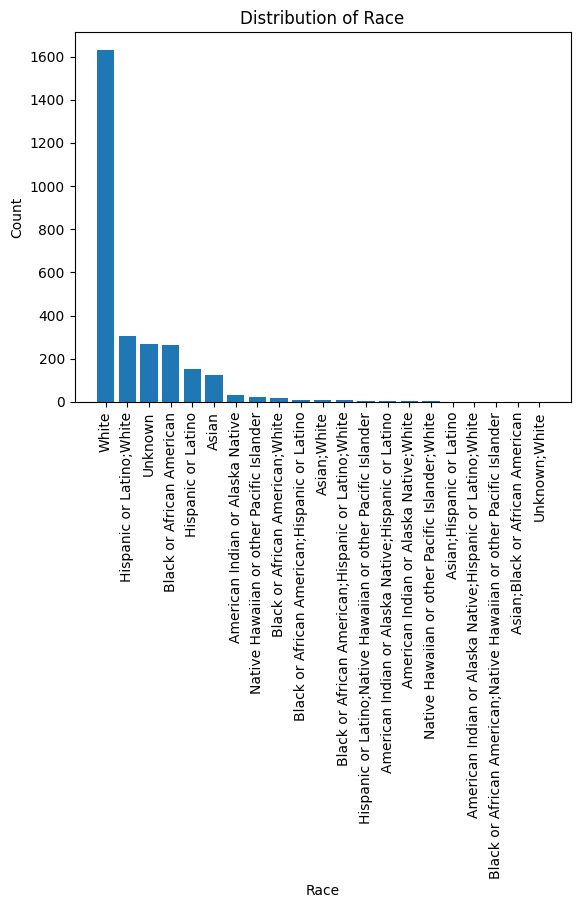

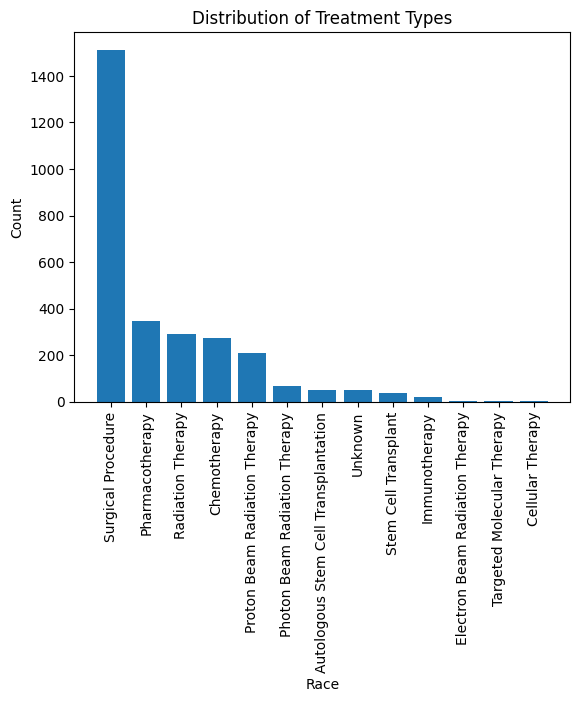

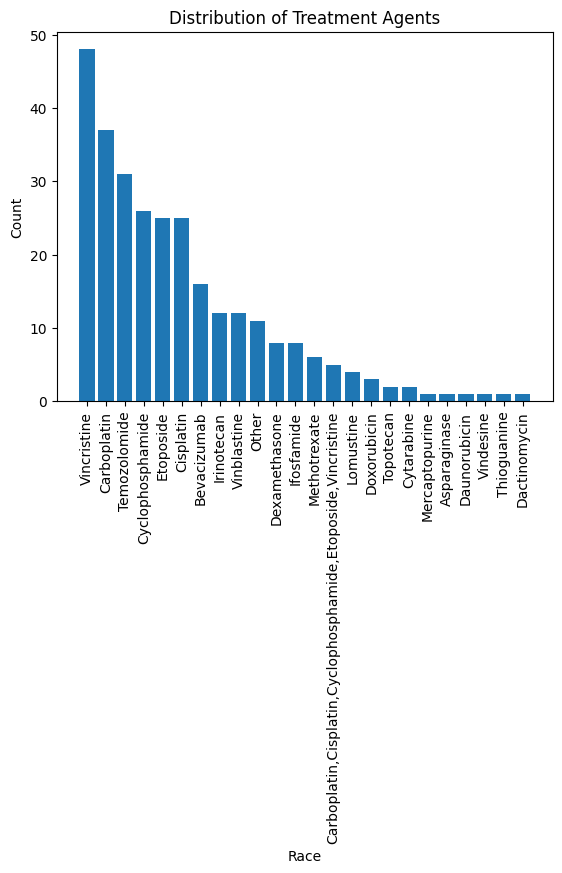

In [60]:
plt.hist(df_final_bayeswork['Survival_Time_Days'].dropna(), bins=50)
plt.axvline(x=730, color='red', linestyle='--', linewidth=2, label='Threshold (730 days)')
mean_survive = df_final_bayeswork['Survival_Time_Days'].dropna().mean()
median_survive = df_final_bayeswork['Survival_Time_Days'].dropna().median()
plt.axvline(x=mean_survive, color='blue', linestyle='--', linewidth=2, label=f'Mean ({mean_survive:.0f} days)')
plt.axvline(x=median_survive, color='green', linestyle='--', linewidth=2, label=f'Median ({median_survive:.0f} days)')
plt.xlabel('Survival Time (Days)')
plt.ylabel("Frequency")
plt.title("Distribution of Survival Time (Days)")
plt.legend()
plt.show()


plt.hist(df_final_bayeswork['Age_at_Diagnosis_Days'].dropna(), bins=50)
mean_age = df_final_bayeswork['Age_at_Diagnosis_Days'].dropna().mean()
median_age = df_final_bayeswork['Age_at_Diagnosis_Days'].dropna().median()
plt.axvline(x=mean_age, color='blue', linestyle='--', linewidth=2, label=f'Mean ({mean_age:.0f} days)')
plt.axvline(x=median_age, color='green', linestyle='--', linewidth=2, label=f'Median ({median_age:.0f} days)')
plt.xlabel('Age at Diagnosis (Days)')
plt.ylabel("Frequency")
plt.title("Distribution of Age at Diagnosis (Days)")
plt.legend()
plt.show()

plt.hist(df_final_bayeswork['Age_Last_Contact'].dropna(), bins=50)
mean_age_last_contact = df_final_bayeswork['Age_Last_Contact'].dropna().mean()
median_age_last_contact = df_final_bayeswork['Age_Last_Contact'].dropna().median()
plt.axvline(x=mean_age_last_contact, color='blue', linestyle='--', linewidth=2, label=f'Mean ({mean_age_last_contact:.0f} days)')
plt.axvline(x=median_age_last_contact, color='green', linestyle='--', linewidth=2, label=f'Median ({median_age_last_contact:.0f} days)')
plt.xlabel('Age at Diagnosis (Days)')
plt.ylabel("Frequency")
plt.title("Distribution of Age at Last Contacted")
plt.legend()
plt.show()


plt.bar(df_final_bayeswork['Race'].value_counts().index, df_final_bayeswork['Race'].value_counts())
plt.xticks(rotation=90)
plt.xlabel("Race")
plt.ylabel("Count")
plt.title("Distribution of Race")
plt.show()

plt.bar(df_final_bayeswork['Treatment Type'].value_counts().index, df_final_bayeswork['Treatment Type'].value_counts())
plt.xticks(rotation=90)
plt.xlabel("Race")
plt.ylabel("Count")
plt.title("Distribution of Treatment Types")
plt.show()


plt.bar(df_final_bayeswork.loc[df_final_bayeswork['Treatment Agent'] != "Not Reported"]['Treatment Agent'].value_counts().index, \
    df_final_bayeswork.loc[df_final_bayeswork['Treatment Agent'] != "Not Reported"]['Treatment Agent'].value_counts())
plt.xticks(rotation=90)
plt.xlabel("Race")
plt.ylabel("Count")
plt.title("Distribution of Treatment Agents")
plt.show()



In [62]:
bayes_net_data = df_final_bayeswork.drop(columns=['Participant ID', "Treatment ID", "Study_ID", "Age at Treatment Start", "Age at Treatment End", "Age_missing_flag", "Event_Status"], axis=1)

numeric_cols = ['Age_at_Diagnosis_Days', 'Survival_Time_Days', 'Age_Last_Contact']
for col in numeric_cols:
    if col in bayes_net_data.columns:
        bayes_net_data[col] = pd.to_numeric(bayes_net_data[col], errors='coerce')

bayes_net_data['Age_Group'] = pd.cut(
    bayes_net_data['Age_at_Diagnosis_Days'], 
    bins=[0, 365, 1825, 5475, 10950, float('inf')],  # 0-1yr, 1-5yr, 5-15yr, 15-30yr, 30+yr
    labels=['Infant', 'Toddler', 'Child', 'Adolescent', 'Adult']
)

bayes_net_data['Survival_Group'] = pd.cut(
    bayes_net_data['Survival_Time_Days'],
    bins=[-float('inf'), 0, 365, 1825, float('inf')],  # negative (error), <1yr, 1-5yr, 5+yr
    labels=['Negative', 'Short', 'Medium', 'Long']
)

bayes_net_data['Age_Last_Contact_Group'] = pd.cut(
    bayes_net_data['Age_Last_Contact'],
    bins=[0, 1825, 5475, 10950, float('inf')],  # 0-5yr, 5-15yr, 15-30yr, 30+yr
    labels=['Young', 'Child', 'Teen', 'Adult']
)

bayes_net_data = bayes_net_data.drop(columns=['Age_at_Diagnosis_Days', 'Survival_Time_Days', 'Age_Last_Contact'])

race_counts = bayes_net_data['Race'].value_counts()

threshold = len(bayes_net_data) * 0.05
bayes_net_data['Race'] = bayes_net_data['Race'].apply(
    lambda x: x if race_counts.get(x, 0) >= threshold else 'Other'
)


for col in bayes_net_data.columns:
    bayes_net_data[col] = bayes_net_data[col].astype(str)

bayes_net_data = bayes_net_data.replace('nan', 'Unknown')
bayes_net_data = bayes_net_data.fillna('Unknown')

bayes_net_data.drop(columns=['is_cns_tumor'], inplace=True)

In [64]:
bayes_net_data.columns

Index(['Treatment Type', 'Treatment Agent', 'Race', 'Sex at Birth', 'Target',
       'Age_Group', 'Survival_Group', 'Age_Last_Contact_Group'],
      dtype='object')

For our selection of features (treatment type, treatment agent, race, sex at birth, age group, survival group, and age last contact group), we verified their association with our target variable by evaluating their chi squared contingency. Notably, all of our variables has some significant association with our target variable, with the most pronounced significance outside of our survival grouping variable being the treatment type for a patient.

In [65]:
print(f"\nTarget distribution:")
print(bayes_net_data['Target'].value_counts())

associations = []
for col in bayes_net_data.columns:
    if col != 'Target':
        # Create contingency table
        contingency_table = pd.crosstab(bayes_net_data[col], bayes_net_data['Target'])
        
        # Perform chi-square test
        try:
            chi2, p_value, dof, expected = chi2_contingency(contingency_table)
            
            associations.append({
                'Variable': col,
                'Chi2': chi2,
                'P-value': p_value,
                'DOF': dof,
                'Significant': 'Yes' if p_value < 0.05 else 'No'
            })
            
            # Only print significant ones during the loop for brevity
            if p_value < 0.01:  # Very significant
                print(f"\n{col}:")
                print(f"  Chi-square: {chi2:.4f}, P-value: {p_value:.6f}, DOF: {dof}")
        except Exception as e:
            print(f"\n{col}: ERROR - {e}")
            associations.append({
                'Variable': col,
                'Chi2': np.nan,
                'P-value': np.nan,
                'DOF': np.nan,
                'Significant': 'Error'
            })

# Sort by p-value
associations_df = pd.DataFrame(associations).sort_values('P-value')

print("\n" + "="*80)
print("TOP 20 Variables ranked by association with Target (Poor Prognosis):")
print("="*80)
print(associations_df.head(20).to_string(index=False))

# Show variables that are significantly associated
sig_vars = associations_df[associations_df['Significant'] == 'Yes']['Variable'].tolist()
print(f"\nSignificantly associated variables (p < 0.05): {len(sig_vars)}")

# Categorize significant variables
diagnosis_cols = [v for v in sig_vars if any(keyword in v.lower() for keyword in ['diagnosis', 'tumor', 'disease', 'grade', 'stage', 'staging'])]
response_cols = [v for v in sig_vars if any(keyword in v.lower() for keyword in ['response', 'category', 'system'])]
survival_cols = [v for v in sig_vars if any(keyword in v.lower() for keyword in ['survival', 'event', 'cause'])]
treatment_cols = [v for v in sig_vars if any(keyword in v.lower() for keyword in ['treatment', 'agent'])]
demographic_cols = [v for v in sig_vars if any(keyword in v.lower() for keyword in ['age', 'race', 'sex'])]

print(f"\n{'='*80}")
print("SIGNIFICANT FEATURES BY CATEGORY:")
print(f"{'='*80}")

if diagnosis_cols:
    print(f"\nDIAGNOSIS features ({len(diagnosis_cols)}):")
    for col in diagnosis_cols[:10]:
        p_val = associations_df[associations_df['Variable'] == col]['P-value'].values[0]
        chi2_val = associations_df[associations_df['Variable'] == col]['Chi2'].values[0]
        print(f"  - {col}: Chi2={chi2_val:.2f}, p={p_val:.6f}")

if treatment_cols:
    print(f"\nTREATMENT features ({len(treatment_cols)}):")
    for col in treatment_cols[:10]:
        p_val = associations_df[associations_df['Variable'] == col]['P-value'].values[0]
        chi2_val = associations_df[associations_df['Variable'] == col]['Chi2'].values[0]
        print(f"  - {col}: Chi2={chi2_val:.2f}, p={p_val:.6f}")

if response_cols:
    print(f"\nTREATMENT RESPONSE features ({len(response_cols)}):")
    for col in response_cols[:10]:
        p_val = associations_df[associations_df['Variable'] == col]['P-value'].values[0]
        chi2_val = associations_df[associations_df['Variable'] == col]['Chi2'].values[0]
        print(f"  - {col}: Chi2={chi2_val:.2f}, p={p_val:.6f}")

if survival_cols:
    print(f"\nSURVIVAL features ({len(survival_cols)}):")
    for col in survival_cols[:10]:
        p_val = associations_df[associations_df['Variable'] == col]['P-value'].values[0]
        chi2_val = associations_df[associations_df['Variable'] == col]['Chi2'].values[0]
        print(f"  - {col}: Chi2={chi2_val:.2f}, p={p_val:.6f}")

if demographic_cols:
    print(f"\nDEMOGRAPHIC features ({len(demographic_cols)}):")
    for col in demographic_cols[:10]:
        p_val = associations_df[associations_df['Variable'] == col]['P-value'].values[0]
        chi2_val = associations_df[associations_df['Variable'] == col]['Chi2'].values[0]
        print(f"  - {col}: Chi2={chi2_val:.2f}, p={p_val:.6f}")

print(f"\n{'='*80}")
print(f"SUMMARY: {len(sig_vars)} total features significantly associated with poor prognosis")
print(f"{'='*80}")


Target distribution:
Target
0    2553
1     319
Name: count, dtype: int64

Treatment Type:
  Chi-square: 241.0983, P-value: 0.000000, DOF: 12

Treatment Agent:
  Chi-square: 204.3521, P-value: 0.000000, DOF: 24

Race:
  Chi-square: 49.7507, P-value: 0.000000, DOF: 5

Sex at Birth:
  Chi-square: 15.3395, P-value: 0.000090, DOF: 1

Survival_Group:
  Chi-square: 544.7381, P-value: 0.000000, DOF: 3

Age_Last_Contact_Group:
  Chi-square: 177.4289, P-value: 0.000000, DOF: 3

TOP 20 Variables ranked by association with Target (Poor Prognosis):
              Variable       Chi2       P-value  DOF Significant
        Survival_Group 544.738095 9.604056e-118    3         Yes
        Treatment Type 241.098259  9.796140e-45   12         Yes
Age_Last_Contact_Group 177.428865  3.167313e-38    3         Yes
       Treatment Agent 204.352142  1.499993e-30   24         Yes
                  Race  49.750667  1.558522e-09    5         Yes
          Sex at Birth  15.339457  8.982079e-05    1         Yes
 

From these results, we construct two bayes nets, one including our target and one without. Both of our models attain BIC scores of -19410.74 and -20139.21, with models trained with the constrained hill climb methodology working the best. In both models, sex at birth was not found to have any significant conditional association with any of our variables. While treatment agent attains a conditional association with our target variable through treatment type when our target is introduced to the bayesian network, it loses that association with the target variable.

Across our bayesian networks, we note a difference in survival times for different races, where shorter survival times attain conditional probabilities for non-white participants less than 0.15, while longer survival times survival times have conditional probabilities for white participants in upwards of 0.5. This may be due to the class imbalance in our data, as the majority of participants studied where white. 

Medium survival times have high conditional probabilites with treatment types like cellular transplants (0.75), while long survival times have high conditional probabilites for long survival times (0.11). Both of these results make sense as these are both prove, common, and effective treatments for various forms of CNS. We also noted some interesting applications of treatments across age ranges as listed below.

Child | Radiation = 0.88

Toddlers | Cellular Therapy = 0.71

Teenagers | Electron Beam Radiation = 0.8

Adolescents | Photon Beat Radiation = 0.3

Both of our bayes nets attain BIC scores in the -19000s, with our model include treatments attaining a more negative score (indicating better model fit given its complexity).

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'Treatment Type': 'C', 'Treatment Agent': 'C', 'Race': 'C', 'Sex at Birth': 'C', 'Age_Group': 'C', 'Survival_Group': 'C', 'Age_Last_Contact_Group': 'C'}


  0%|          | 0/5 [00:00<?, ?it/s]

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'Treatment Type': 'C', 'Treatment Agent': 'C', 'Race': 'C', 'Sex at Birth': 'C', 'Age_Group': 'C', 'Survival_Group': 'C', 'Age_Last_Contact_Group': 'C'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'Treatment Type': 'C', 'Treatment Agent': 'C', 'Race': 'C', 'Sex at Birth': 'C', 'Age_Group': 'C', 'Survival_Group': 'C', 'Age_Last_Contact_Group': 'C'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'Treatment Type': 'C', 'Treatment Agent': 'C', 'Race': 'C', 'Sex at Birth': 'C', 'Age_Group': 'C', 'Survival_Group': 'C', 'Age_Last_Contact_Group': 'C'}


  0%|          | 0/1000 [00:00<?, ?it/s]

PC edges: 6
Constrained Hill Climb edges: 4
<class 'graphviz.graphs.Digraph'>


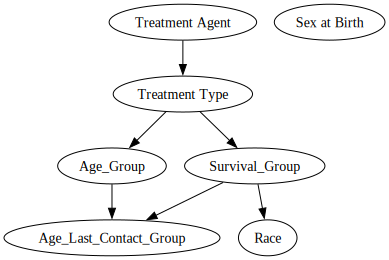

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'Treatment Type': 'C', 'Treatment Agent': 'C', 'Race': 'C', 'Sex at Birth': 'C', 'Age_Group': 'C', 'Survival_Group': 'C', 'Age_Last_Contact_Group': 'C'}



Model: Constrained Hill Climb
Number of edges: 4
Number of nodes: 7


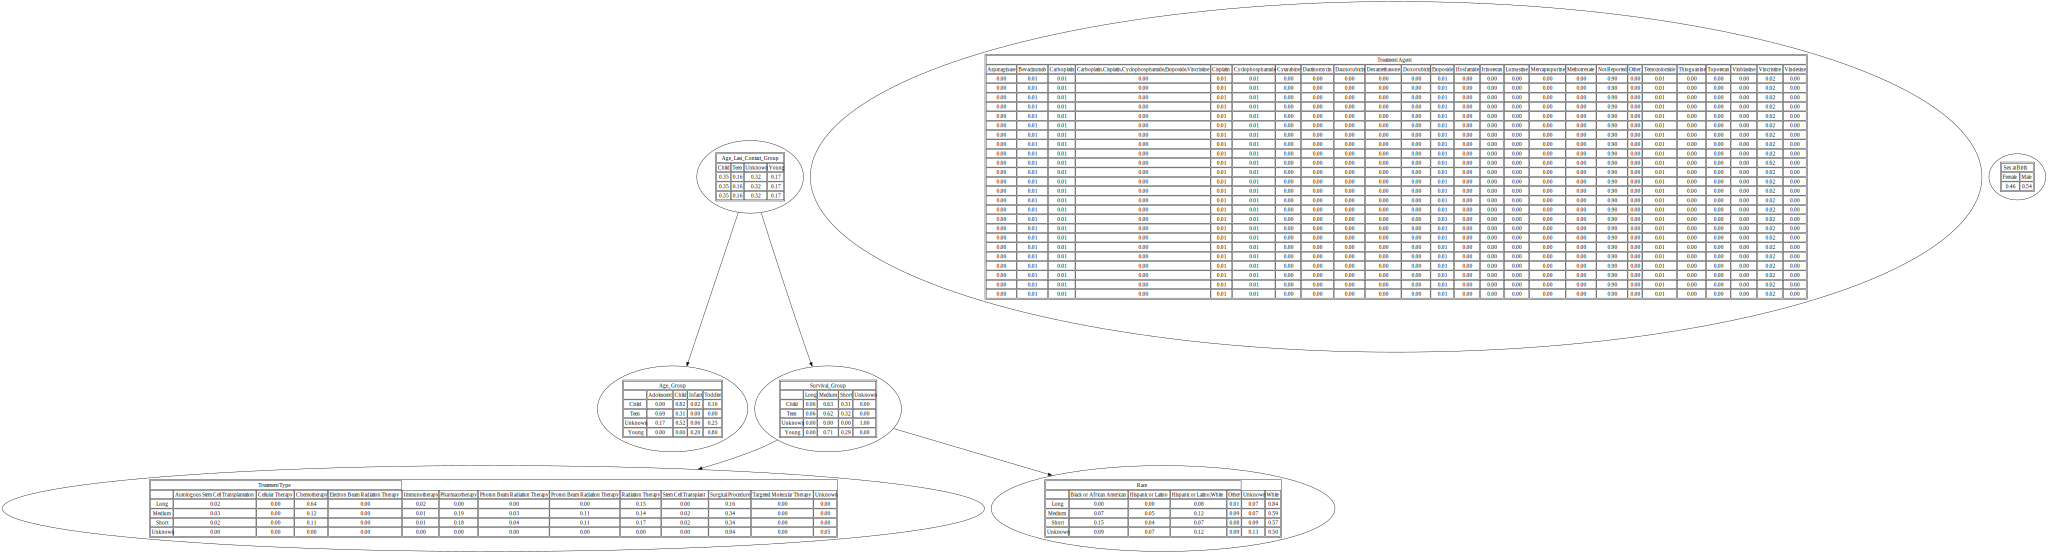

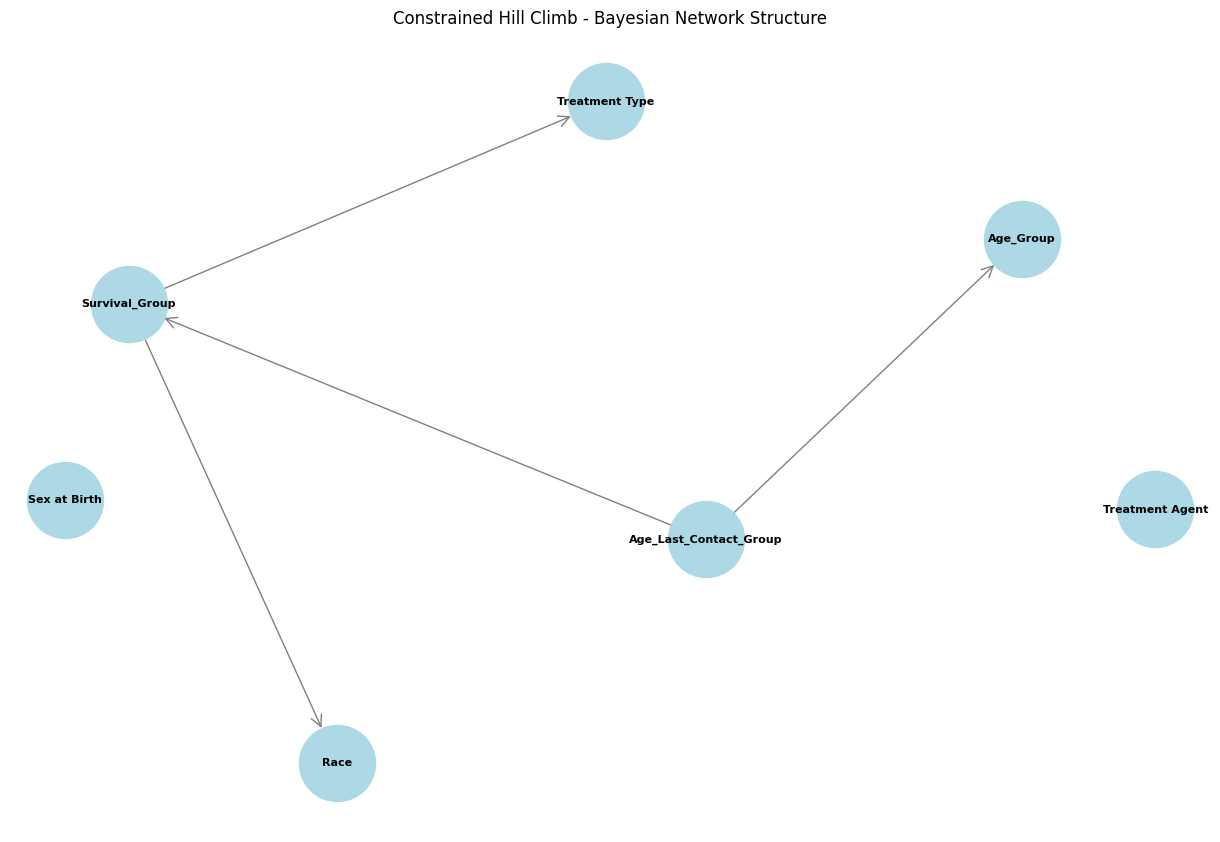

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'Treatment Type': 'C', 'Treatment Agent': 'C', 'Race': 'C', 'Sex at Birth': 'C', 'Age_Group': 'C', 'Survival_Group': 'C', 'Age_Last_Contact_Group': 'C'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'Treatment Type': 'C', 'Treatment Agent': 'C', 'Race': 'C', 'Sex at Birth': 'C', 'Age_Group': 'C', 'Survival_Group': 'C', 'Age_Last_Contact_Group': 'C'}


BIC score: -19178.16
(Lower BIC is better)

Model: PC Algorithm
Number of edges: 6
Number of nodes: 7
(Converted PDAG to DAG)


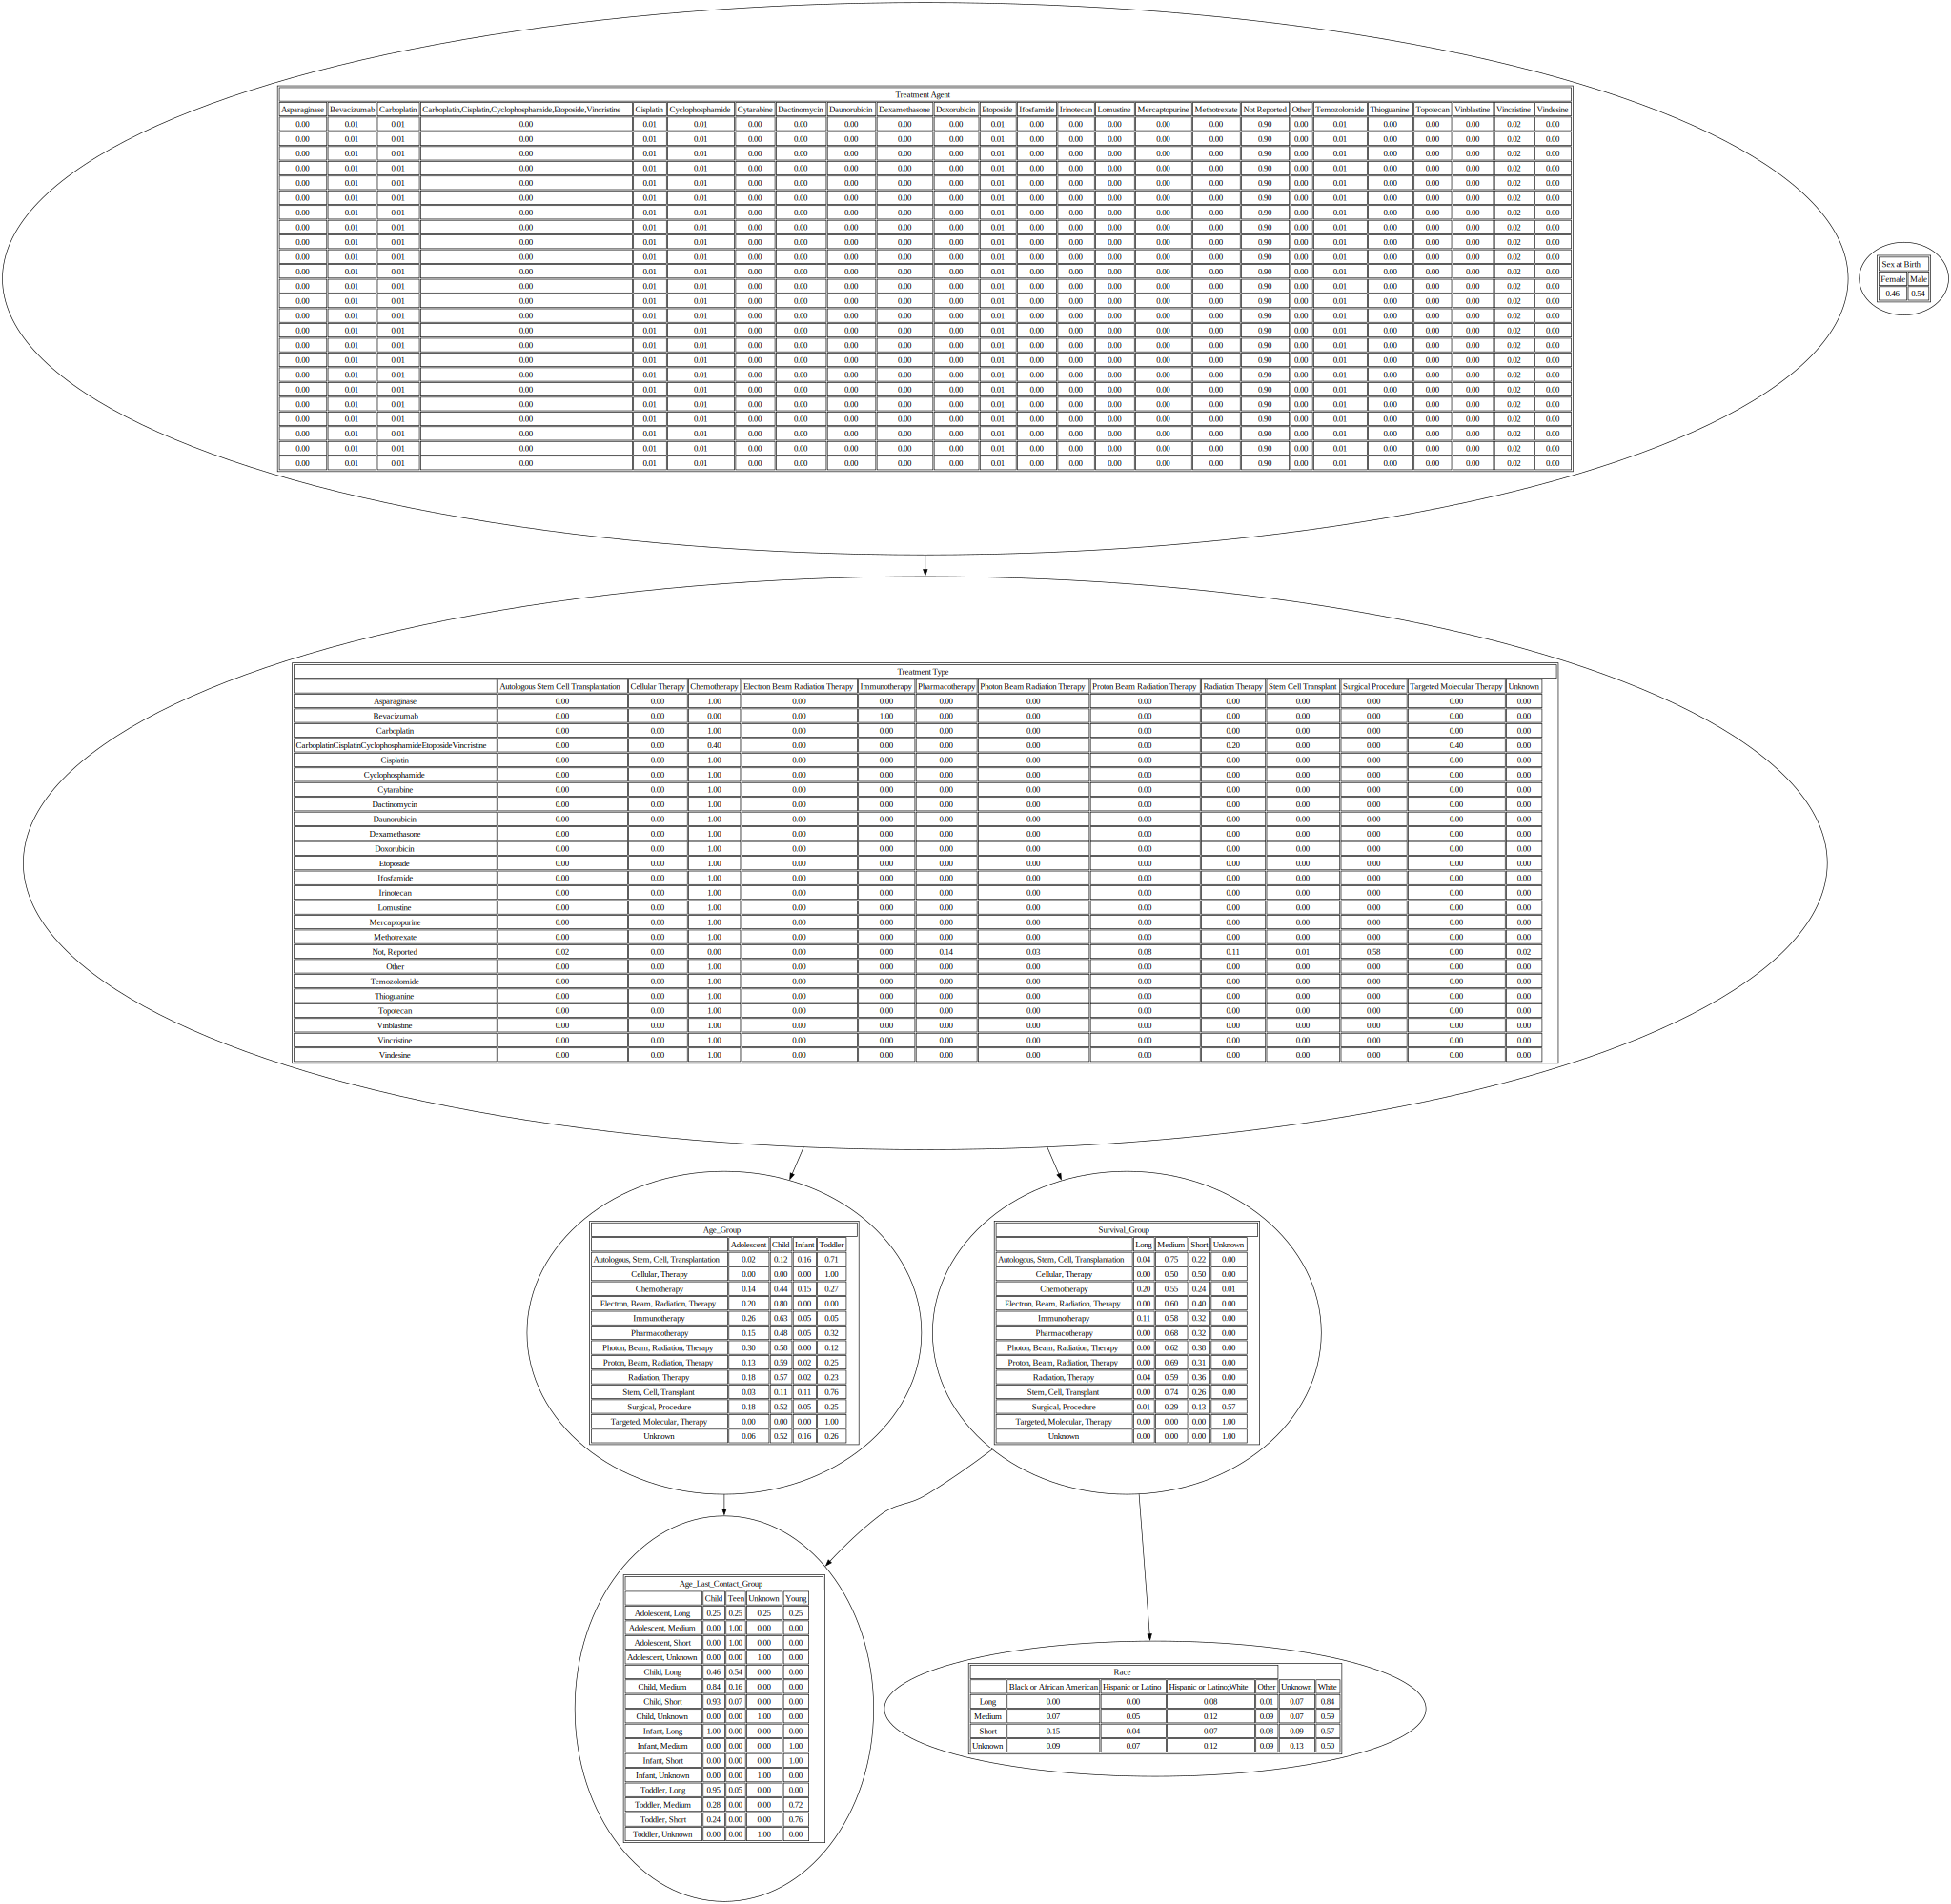

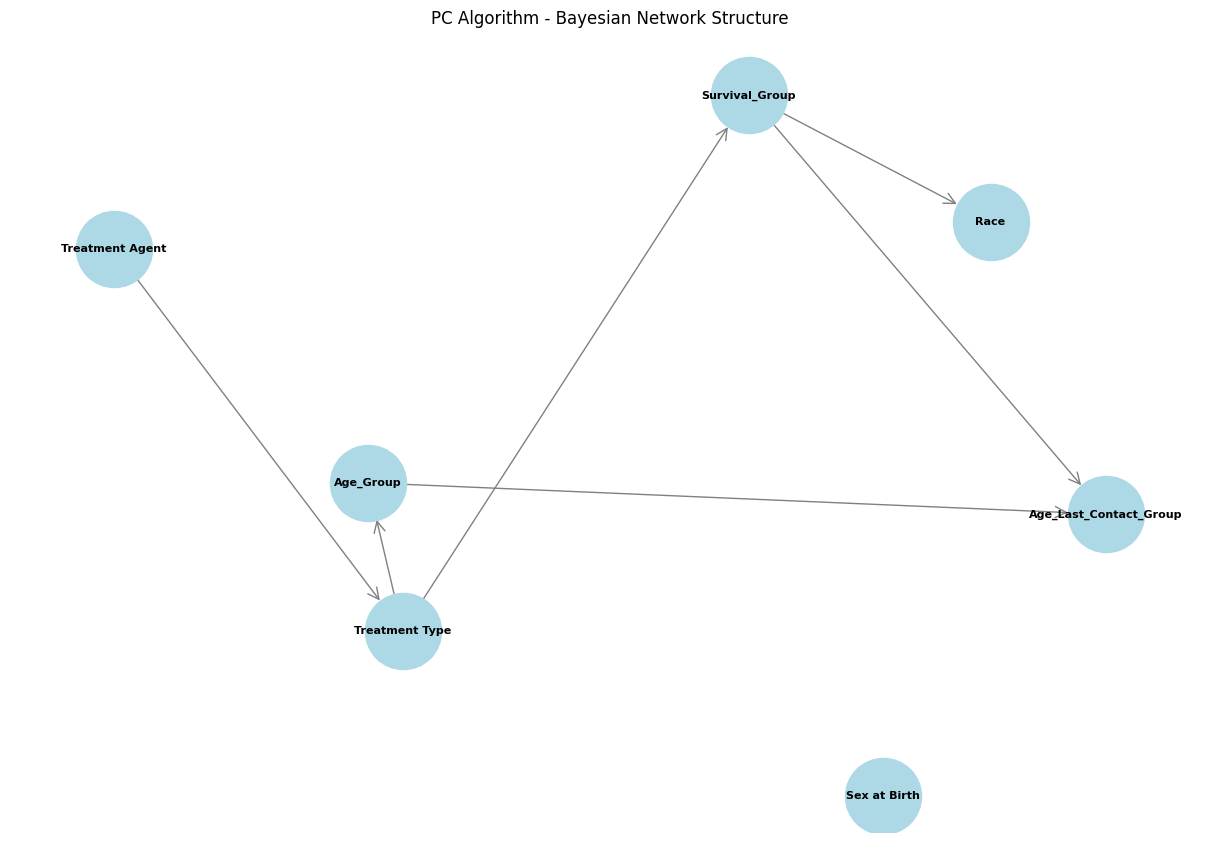

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'Treatment Type': 'C', 'Treatment Agent': 'C', 'Race': 'C', 'Sex at Birth': 'C', 'Age_Group': 'C', 'Survival_Group': 'C', 'Age_Last_Contact_Group': 'C'}


BIC score: -19410.74
(Lower BIC is better)


In [ ]:
dataset_demo_bayes_net = bayes_net_data.drop(columns=[ "Target"], axis=1)
est_pc = PC(dataset_demo_bayes_net)
best_pc_model = est_pc.estimate()


est_hill_constrained = HillClimbSearch(dataset_demo_bayes_net)
best_hill_constrained_model = est_hill_constrained.estimate(
    scoring_method=BIC(dataset_demo_bayes_net),
    max_indegree=3,
    max_iter=1000
)

print("PC edges:", len(best_pc_model.edges()))
print("Constrained Hill Climb edges:", len(best_hill_constrained_model.edges()))

# Visualize PC model
model_pc = CausalGraphicalModel(nodes=best_pc_model.nodes(), edges=best_pc_model.edges())

dot = model_pc.draw()
print(type(dot))
display(dot)
dot.render(filename="../graphs_and_figures/pgm_participant_data_pc", format="pdf")


# Visualize Constrained Hill Climb model
model_constrained = CausalGraphicalModel(nodes=best_hill_constrained_model.nodes(), edges=best_hill_constrained_model.edges())

dot = model_constrained.draw()
#print(type(dot))
#display(dot)
dot.render(filename="../graphs_and_figures/pgm_participant_data_hill_constrained", format="pdf")

mymodels = [
    ("Constrained Hill Climb", best_hill_constrained_model),
    ("PC Algorithm", best_pc_model)
]

for name, model in mymodels:
    print(f"\n{'='*60}")
    print(f"Model: {name}")
    print(f"{'='*60}")
    print(f"Number of edges: {len(model.edges())}")
    print(f"Number of nodes: {len(model.nodes())}")
    
    if hasattr(model, 'to_dag'):
        model_dag = model.to_dag()
        print("(Converted PDAG to DAG)")
    else:
        model_dag = model
    
    network = DiscreteBayesianNetwork(model_dag)
    mle = MaximumLikelihoodEstimator(network, dataset_demo_bayes_net)
    
    for cpd in mle.get_parameters():
        network.add_cpds(cpd)

    dot = pgm.visualize_model(network)
    display(dot)
    
    # Convert to NetworkX DiGraph
    G = nx.DiGraph()
    G.add_nodes_from(network.nodes())
    G.add_edges_from(network.edges())
    
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G, seed=42, k=2, iterations=50)
    nx.draw(G, pos, 
            with_labels=True, 
            node_color='lightblue', 
            node_size=3000, 
            font_size=8, 
            font_weight='bold',
            arrows=True,
            arrowsize=20,
            edge_color='gray',
            arrowstyle='->')
    plt.title(f"{name} - Bayesian Network Structure")
    plt.tight_layout()
    plt.show()
    
    bic_scorer = BIC(dataset_demo_bayes_net)
    bic_score = bic_scorer.score(model_dag)
    print(f'BIC score: {bic_score:.2f}')
    print(f"(Lower BIC is better)")


INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'Treatment Type': 'C', 'Treatment Agent': 'C', 'Race': 'C', 'Sex at Birth': 'C', 'Target': 'C', 'Age_Group': 'C', 'Survival_Group': 'C', 'Age_Last_Contact_Group': 'C'}


  0%|          | 0/5 [00:00<?, ?it/s]

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'Treatment Type': 'C', 'Treatment Agent': 'C', 'Race': 'C', 'Sex at Birth': 'C', 'Target': 'C', 'Age_Group': 'C', 'Survival_Group': 'C', 'Age_Last_Contact_Group': 'C'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'Treatment Type': 'C', 'Treatment Agent': 'C', 'Race': 'C', 'Sex at Birth': 'C', 'Target': 'C', 'Age_Group': 'C', 'Survival_Group': 'C', 'Age_Last_Contact_Group': 'C'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'Treatment Type': 'C', 'Treatment Agent': 'C', 'Race': 'C', 'Sex at Birth': 'C', 'Target': 'C', 'Age_Group': 'C', 'Survival_Group': 'C', 'Age_Last_Contact_Group': 'C'}


  0%|          | 0/1000 [00:00<?, ?it/s]

PC edges: 6
Constrained Hill Climb edges: 6


INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'Treatment Type': 'C', 'Treatment Agent': 'C', 'Race': 'C', 'Sex at Birth': 'C', 'Target': 'C', 'Age_Group': 'C', 'Survival_Group': 'C', 'Age_Last_Contact_Group': 'C'}



Model: Constrained Hill Climb
Number of edges: 6
Number of nodes: 8


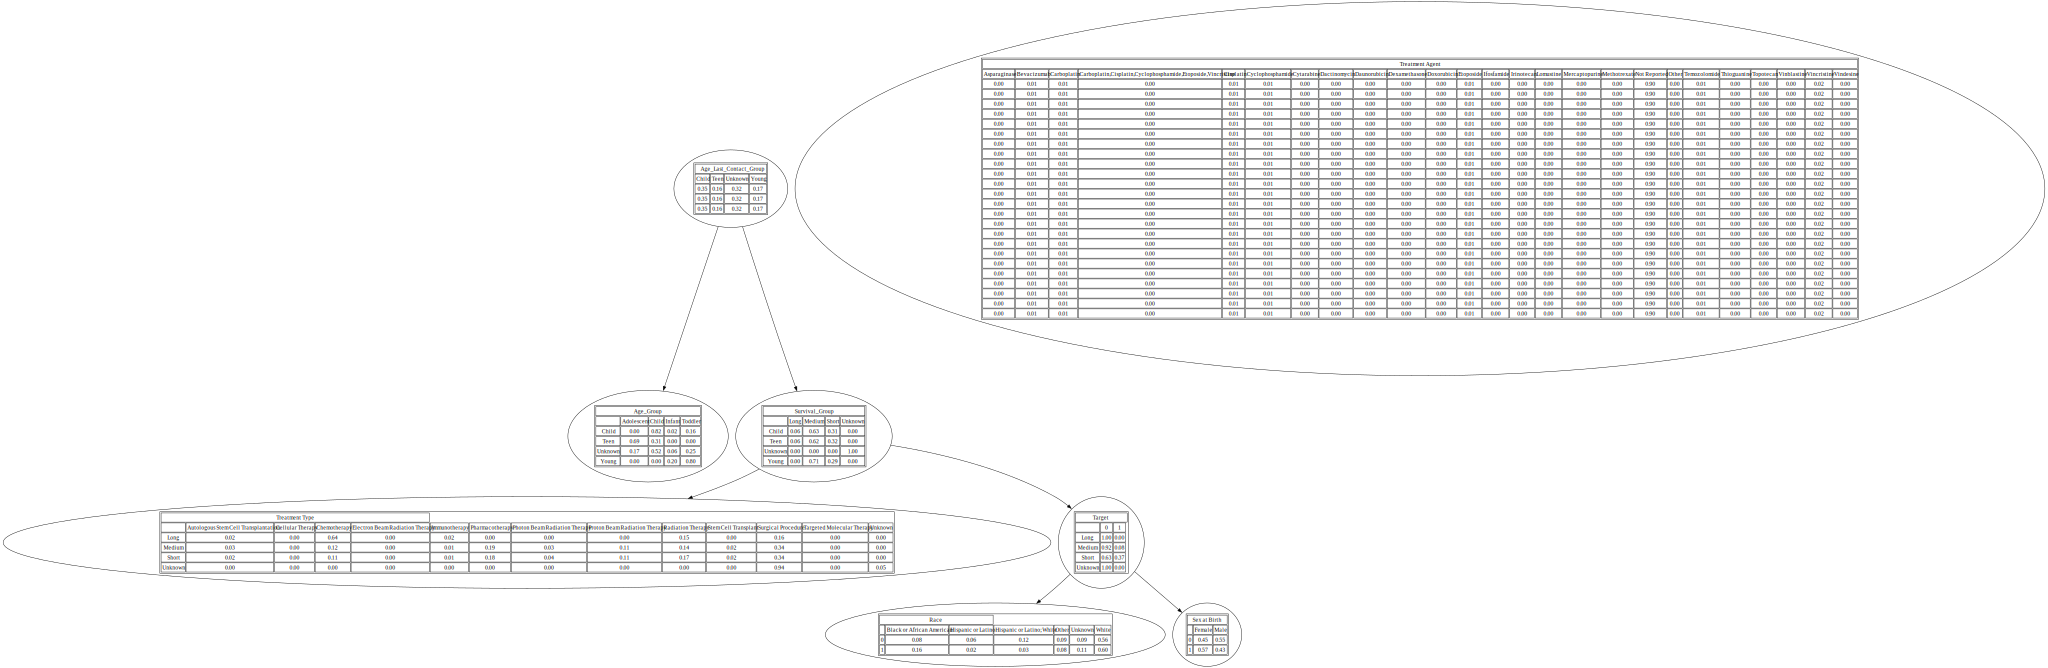

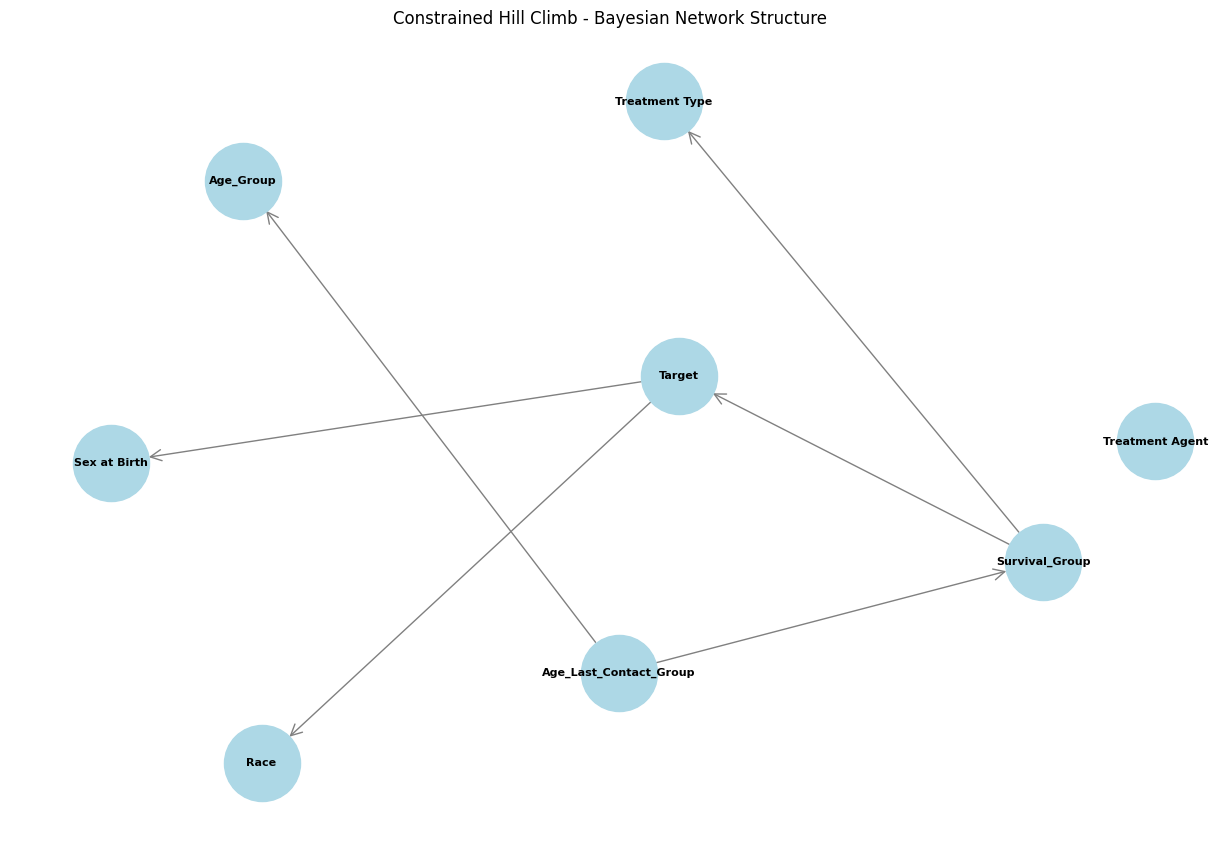

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'Treatment Type': 'C', 'Treatment Agent': 'C', 'Race': 'C', 'Sex at Birth': 'C', 'Target': 'C', 'Age_Group': 'C', 'Survival_Group': 'C', 'Age_Last_Contact_Group': 'C'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'Treatment Type': 'C', 'Treatment Agent': 'C', 'Race': 'C', 'Sex at Birth': 'C', 'Target': 'C', 'Age_Group': 'C', 'Survival_Group': 'C', 'Age_Last_Contact_Group': 'C'}


BIC score: -19923.94
(Lower BIC is better)

Model: PC Algorithm
Number of edges: 6
Number of nodes: 8
(Converted PDAG to DAG)


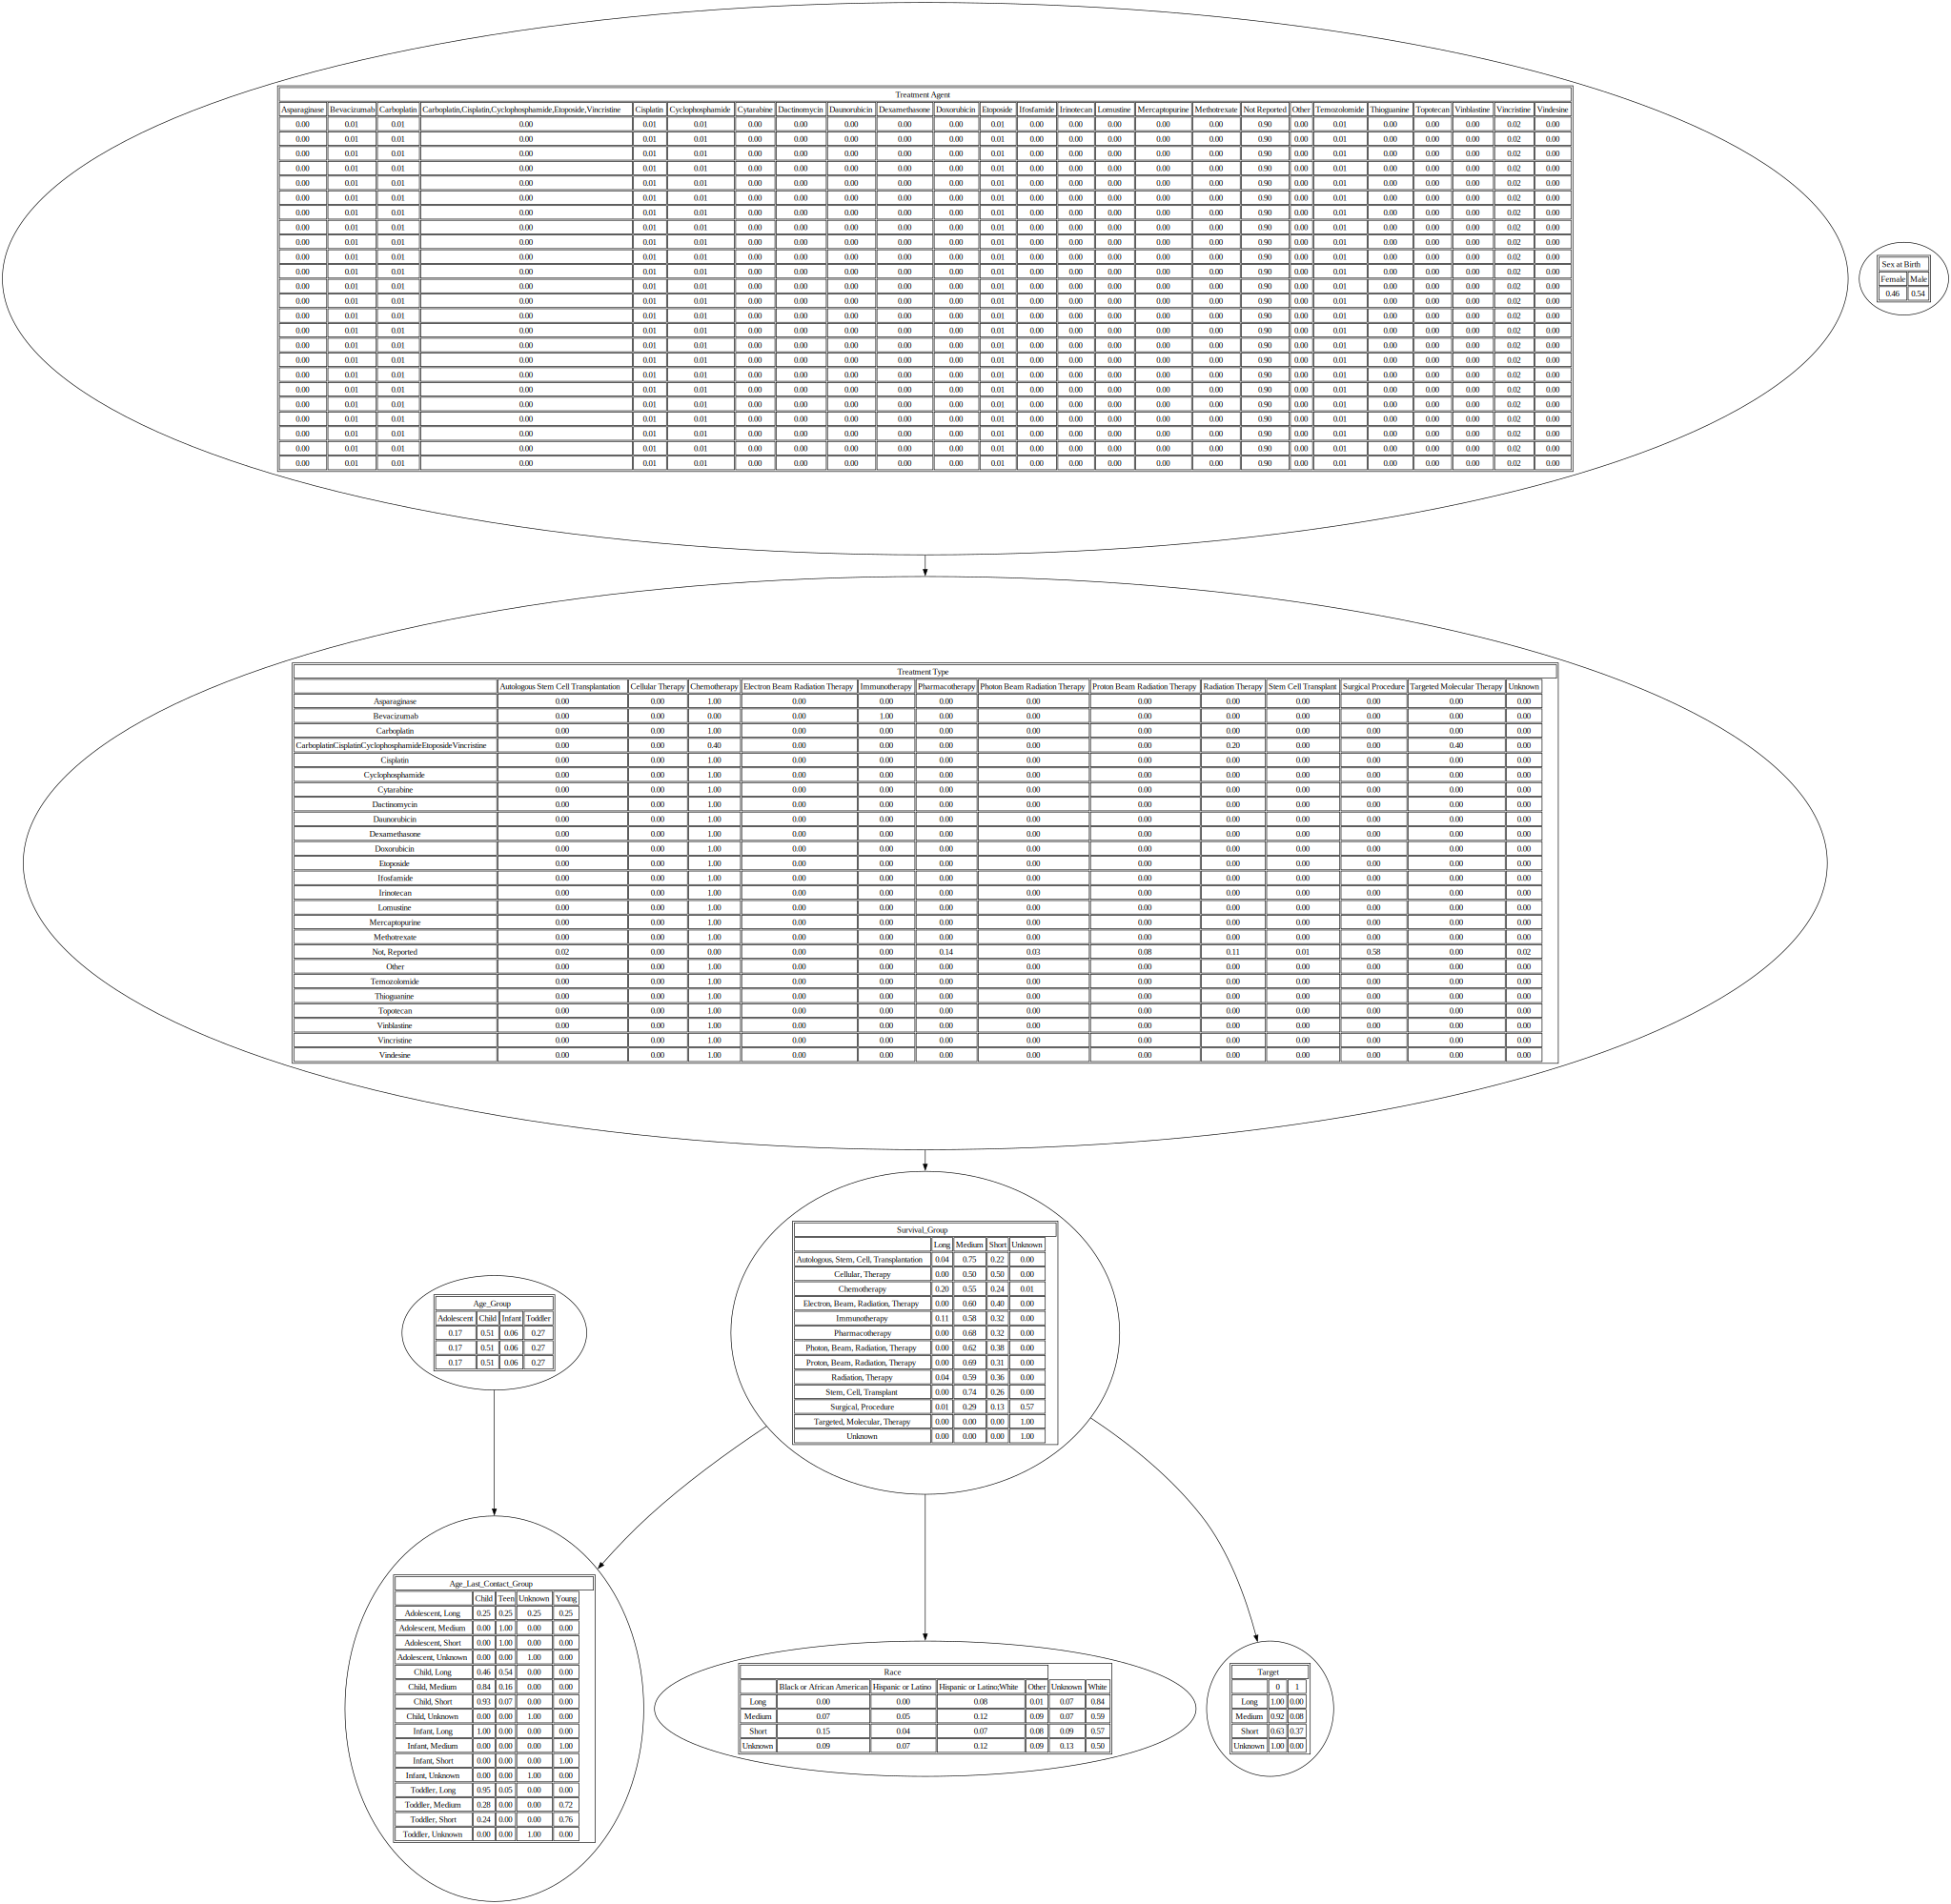

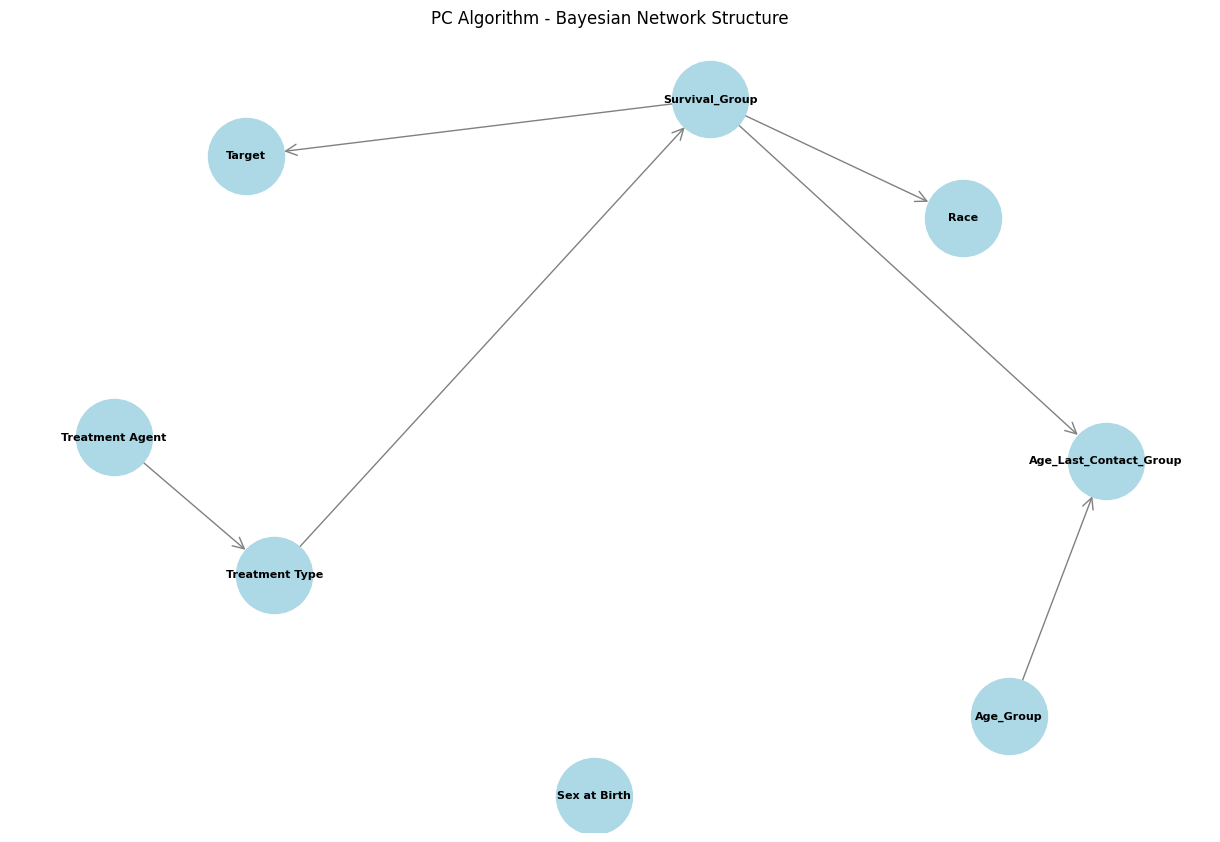

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'Treatment Type': 'C', 'Treatment Agent': 'C', 'Race': 'C', 'Sex at Birth': 'C', 'Target': 'C', 'Age_Group': 'C', 'Survival_Group': 'C', 'Age_Last_Contact_Group': 'C'}


BIC score: -20139.21
(Lower BIC is better)


In [ ]:
est_pc = PC(bayes_net_data)
best_pc_model = est_pc.estimate()


est_hill_constrained = HillClimbSearch(bayes_net_data)
best_hill_constrained_model = est_hill_constrained.estimate(
    scoring_method=BIC(bayes_net_data),
    max_indegree=3,
    max_iter=1000
)

print("PC edges:", len(best_pc_model.edges()))
print("Constrained Hill Climb edges:", len(best_hill_constrained_model.edges()))

# Visualize PC model
model_pc = CausalGraphicalModel(nodes=best_pc_model.nodes(), edges=best_pc_model.edges())

dot = model_pc.draw()
#print(type(dot))
#display(dot)
dot.render(filename="../graphs_and_figures/pgm_participant_data_pc_with_target", format="pdf")


# Visualize Constrained Hill Climb model
model_constrained = CausalGraphicalModel(nodes=best_hill_constrained_model.nodes(), edges=best_hill_constrained_model.edges())

dot = model_constrained.draw()
#print(type(dot))
#display(dot)
dot.render(filename="../graphs_and_figures/pgm_participant_data_hill_constrained_with_target", format="pdf")

mymodels = [
    ("Constrained Hill Climb", best_hill_constrained_model),
    ("PC Algorithm", best_pc_model)
]

for name, model in mymodels:
    print(f"\n{'='*60}")
    print(f"Model: {name}")
    print(f"{'='*60}")
    print(f"Number of edges: {len(model.edges())}")
    print(f"Number of nodes: {len(model.nodes())}")
    
    if hasattr(model, 'to_dag'):
        model_dag = model.to_dag()
        print("(Converted PDAG to DAG)")
    else:
        model_dag = model
    
    network = DiscreteBayesianNetwork(model_dag)
    mle = MaximumLikelihoodEstimator(network, bayes_net_data)
    
    for cpd in mle.get_parameters():
        network.add_cpds(cpd)
    
    dot = pgm.visualize_model(network)
    display(dot)
    
    # Convert to NetworkX DiGraph
    G = nx.DiGraph()
    G.add_nodes_from(network.nodes())
    G.add_edges_from(network.edges())
    
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G, seed=42, k=2, iterations=50)
    nx.draw(G, pos, 
            with_labels=True, 
            node_color='lightblue', 
            node_size=3000, 
            font_size=8, 
            font_weight='bold',
            arrows=True,
            arrowsize=20,
            edge_color='gray',
            arrowstyle='->')
    plt.title(f"{name} - Bayesian Network Structure")
    plt.tight_layout()
    plt.show()
    
    bic_scorer = BIC(bayes_net_data)
    bic_score = bic_scorer.score(model_dag)
    print(f'BIC score: {bic_score:.2f}')
    print(f"(Lower BIC is better)")


Sources:

Cancer Research UK. (n.d.). Temozolomide (Temodal). https://www.cancerresearchuk.org/about-cancer/treatment/drugs/temozolomide#:~:text=Temozolomide%20is%20a%20type%20of,neuroendocrine%20tumours

Awosika, A. O., Below, J., & Das, J. M. (2023, October 30). Vincristine. In StatPearls [Internet]. StatPearls Publishing. https://www.ncbi.nlm.nih.gov/books/NBK537122/
 
Mayo Clinic. (n.d.). Carboplatin (intravenous route): Description. https://www.mayoclinic.org/drugs-supplements/carboplatin-intravenous-route/description/drg-20062578